In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
import gc

In [2]:
polls_2020 = 'C:\\Users\\cmfre\\Downloads\\polls\\polls\\presidential_poll_averages_2020.csv'
past_polls = 'C:\\Users\\cmfre\\Downloads\\polls\\polls\\pres_pollaverages_1968-2016.csv'

data_2020 = pd.read_csv(polls_2020)
data_2016 = pd.read_csv(past_polls)

In [3]:
data_2016 = data_2016.loc[data_2016.cycle==2016,data_2020.columns]

In [4]:
data_2020['s_date'] = pd.to_datetime(data_2020.modeldate)
data_2016['s_date'] = pd.to_datetime(data_2016.modeldate)

In [5]:
##wtf is up with 3 NE districts versus 2?

In [6]:
results_2016 = pd.read_excel('C:\\Users\\cmfre\\Downloads\\federalelections2016.xlsx',sheet_name='2016 Pres General Results')

In [7]:
results_2016 = results_2016.loc[results_2016['WINNER INDICATOR']=='W',:]

In [8]:
data_2016['new_state'] = data_2016.state.replace('ME-1','Maine').replace('ME-2','Maine').replace('NE-1','Nebraska').replace('NE-2','Nebraska').replace('NE-3','Nebraska')
data_2020['new_state'] = data_2020.state.replace('ME-1','Maine').replace('ME-2','Maine').replace('NE-1','Nebraska').replace('NE-2','Nebraska').replace('NE-3','Nebraska')

In [9]:
data_2016 = data_2016.loc[(data_2016.state!='NE-1') & (data_2016.state!='NE-2') & (data_2016.state!='NE-3') & (data_2016.state!='ME-1') & (data_2016.state!='ME-2'),:]
data_2020 = data_2020.loc[(data_2020.state!='NE-1') & (data_2020.state!='NE-2') & (data_2020.state!='NE-3') & (data_2020.state!='ME-1') & (data_2020.state!='ME-2'),:]

In [10]:
polls_avg_2016 = pd.DataFrame(data_2016.loc[(data_2016.s_date>='2016-11-01') & (data_2016.s_date<='2016-11-07'),:].groupby(['candidate_name','new_state']).pct_trend_adjusted.mean()).reset_index()
polls_avg_2016['PARTY'] = polls_avg_2016.candidate_name.replace('Donald Trump','REP').replace('Hillary Rodham Clinton','DEM')
polls_avg_2016['STATE'] = polls_avg_2016.new_state
polls_avg_2016 = polls_avg_2016.pivot(index='STATE',columns='PARTY',values='pct_trend_adjusted').drop(columns=['Gary Johnson'])
polls_avg_2016 = polls_avg_2016.reset_index()

In [11]:
train_data = results_2016.merge(polls_avg_2016,on=['STATE'])

In [12]:
def rep_error_amt(winning_party,winning_amount,rep_pred,dem_pred):
    if winning_party=='REP':
        e_amt = winning_amount-(rep_pred/100)
    else:
        e_amt = winning_amount-(dem_pred/100)
        e_amt = -e_amt
    return(e_amt)

train_data['rep_error'] = train_data.apply(lambda row: rep_error_amt(row['PARTY'],row['GENERAL %'],row['REP'],row['DEM']) ,axis=1)

In [13]:
polls_avg_2020 = pd.DataFrame(data_2020.loc[(data_2020.s_date>='2020-10-27') & (data_2020.s_date<='2020-11-02'),:].groupby(['candidate_name','new_state']).pct_trend_adjusted.mean()).reset_index()
polls_avg_2020 = polls_avg_2020.loc[(polls_avg_2020.candidate_name=='Donald Trump') | (polls_avg_2020.candidate_name=='Joseph R. Biden Jr.'),:]
polls_avg_2020['PARTY'] = polls_avg_2020.candidate_name.replace('Donald Trump','REP').replace('Joseph R. Biden Jr.','DEM')

In [14]:
polls_avg_2020['STATE'] = polls_avg_2020.new_state
polls_avg_2020 = polls_avg_2020.pivot(index='STATE',columns='PARTY',values='pct_trend_adjusted')
polls_avg_2020 = polls_avg_2020.reset_index()

In [15]:
score = polls_avg_2020.merge(train_data[['STATE','rep_error']],on='STATE')

results = pd.DataFrame(columns=['STATE','DEM','REP','sim_number'])
n=5000

for i in range(1,n+1,1):
    df = score.copy()
    rn = np.random.rand()
    df['new_error'] = df.rep_error * rn
    df['DEM'] = (df['DEM']/100) - df['new_error']
    df['REP'] = (df['REP']/100) + df['new_error']
    df['sim_number'] = i
    results = results.append(df[['STATE','DEM','REP','sim_number']])
    del(df)
    if np.mod(i,250)==0:
        print('done with',i,'of',n*2,'simulations where error level is consitent nationally.')
    gc.collect()
for i in range(n+1,n*2+1,1):
    df = score.copy()
    df['new_error'] = df.rep_error.apply(lambda x: x*np.random.rand())
    df['DEM'] = (df['DEM']/100) - df['new_error']
    df['REP'] = (df['REP']/100) + df['new_error']
    df['sim_number'] = i
    results = results.append(df[['STATE','DEM','REP','sim_number']])
    del(df)
    if np.mod(i,250)==0:
        print('done with',i,'of',n*2,'simulations where error level is inconsitent nationally.')
    gc.collect()

done with 250 of 10000 simulations where error level is consitent nationally.
done with 500 of 10000 simulations where error level is consitent nationally.
done with 750 of 10000 simulations where error level is consitent nationally.
done with 1000 of 10000 simulations where error level is consitent nationally.
done with 1250 of 10000 simulations where error level is consitent nationally.
done with 1500 of 10000 simulations where error level is consitent nationally.
done with 1750 of 10000 simulations where error level is consitent nationally.
done with 2000 of 10000 simulations where error level is consitent nationally.
done with 2250 of 10000 simulations where error level is consitent nationally.
done with 2500 of 10000 simulations where error level is consitent nationally.
done with 2750 of 10000 simulations where error level is consitent nationally.
done with 3000 of 10000 simulations where error level is consitent nationally.
done with 3250 of 10000 simulations where error level i

In [16]:
ec_data = pd.read_csv('C:\\Users\\cmfre\\Downloads\\electoral votes by state.csv')

In [17]:
results = results.merge(ec_data,right_on='State',left_on='STATE')
results['winner'] = results.apply(lambda row: 'Trump' if row['REP']>row['DEM'] else 'Biden', axis=1)

In [18]:
final = results.groupby(['sim_number','winner'])['electoral votes'].sum().reset_index()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015BE27E2388>,
      dtype=object)

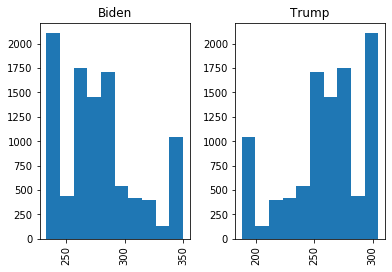

In [19]:
final[['electoral votes','winner']].hist(by='winner')

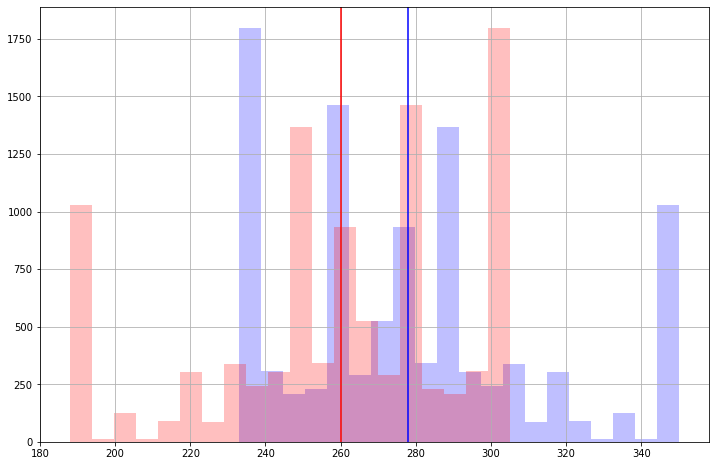

In [20]:
plt.rcParams['figure.figsize'] = [12, 8]

biden = final.loc[final.winner=='Biden','electoral votes']
trump = final.loc[final.winner=='Trump','electoral votes']
biden.hist(bins=20,color='blue',alpha=0.25)
trump.hist(bins=20,color='red',alpha=0.25)
plt.axvline(biden.mean(),color='blue')
plt.axvline(trump.mean(),color='red')

In [21]:
summ = final.pivot(index='sim_number',columns='winner',values='electoral votes')
print(summ.shape)

(10000, 2)


In [24]:
summ['winner'] = summ.apply(lambda row: 'Trump' if row['Trump']>row['Biden'] else 'Biden',axis=1)
trump_wins = len(summ.loc[summ.winner=='Trump',:])
biden_wins = len(summ.loc[summ.winner=='Biden',:])

print('trump wins in',trump_wins,'out of 10000 simulations (',round(trump_wins/float(10000),3)*100,'% of the time) with nate silver\'s current data and the inaccurate polling from 2016 repeating itself, not repeating, or something in between')
print('biden wins in',biden_wins,'out of 10000 simulations (',round(biden_wins/float(10000),3)*100,'% of the time) with nate silver\'s current data and the inaccurate polling from 2016 repeating itself, not repeating, or something in between')

trump wins in 4298 out of 10000 simulations ( 43.0 % of the time) with nate silver's current data and the inaccurate polling from 2016 repeating itself, not repeating, or something in between
biden wins in 5702 out of 10000 simulations ( 56.99999999999999 % of the time) with nate silver's current data and the inaccurate polling from 2016 repeating itself, not repeating, or something in between


In [23]:
print('based on the mean outcome, the states that trump wins are:')
for s in results.STATE.unique():
    t = np.mean(results.loc[(results.STATE==s),'REP'])
    b = np.mean(results.loc[(results.STATE==s),'DEM'])
    if t>b:
        print('      ',s,'(trump:',str(round(float(t)/float(100),4)*int(100))+'%)')
print('based on the mean outcome, the states that biden wins are:')
for s in results.STATE.unique():
    t = np.mean(results.loc[(results.STATE==s),'REP'])
    b = np.mean(results.loc[(results.STATE==s),'DEM'])
    if b>t:
        print('      ',s,'(biden:',str(round(float(b)/float(100),4)*int(100))+'%)')

based on the mean outcome, the states that trump wins are:
       Alabama (trump: 0.6%)
       Alaska (trump: 0.54%)
       Arizona (trump: 0.48%)
       Arkansas (trump: 0.63%)
       Florida (trump: 0.49%)
       Georgia (trump: 0.48%)
       Idaho (trump: 0.64%)
       Indiana (trump: 0.5499999999999999%)
       Iowa (trump: 0.5%)
       Kansas (trump: 0.5499999999999999%)
       Kentucky (trump: 0.6%)
       Louisiana (trump: 0.61%)
       Mississippi (trump: 0.59%)
       Missouri (trump: 0.54%)
       Montana (trump: 0.53%)
       Nebraska (trump: 0.5499999999999999%)
       North Carolina (trump: 0.49%)
       North Dakota (trump: 0.61%)
       Ohio (trump: 0.51%)
       Oklahoma (trump: 0.63%)
       Pennsylvania (trump: 0.48%)
       South Carolina (trump: 0.5499999999999999%)
       South Dakota (trump: 0.59%)
       Tennessee (trump: 0.6%)
       Texas (trump: 0.5%)
       Utah (trump: 0.5599999999999999%)
       West Virginia (trump: 0.66%)
       Wyoming (trump: 0.67999999